In [1]:
import os
import pandas as pd
import numpy as np
from datetime import datetime
import re
from datetime import timedelta

# Majordome

In [40]:
def build_df(filename):
    with open(filename, 'r') as infile, open(filename.replace('.log','_prepd.log'),'w' ) as outfile:
        for line in infile:
            # only want the rows starting with a datetime
            p = re.compile( r'^(\d{4}-\d{2}-\d{2}t\d{2}:\d{2}:\d{2}\.\d{3} \w*)' )
            m = p.match( line.lower() )

            # and only want rows with relevant info to roof operation
            bad_words = ['gcn', '***', 'sql', 'todo', 'modesysteme', '** error **']
            # also want to skip make_scene rows, but not all rows containing make_scene ( some majordome contain make_scene args )
            bad_types = ['make_scene','socket_tel', 'socket_cam', 'check_alert', 'check_hardware', 'make_autofocus']

            if m != None and not any(w in line.lower() for w in bad_words) and not any(t in line[m.start(): m.end()].lower() for t in bad_types):
                line = line.replace(';','')
                # add a clear delimiter for reading into pandas
                line = re.sub(r'^(\d{4}-\d{2}-\d{2}T\d{2}:\d{2}:\d{2}\.\d{3}) (\w+) : (\S)', r'\1 ; \2 ; \3', line)
                outfile.write(line)
                
    df = pd.read_csv(filename.replace('.log','_prepd.log'), header = None, delimiter=';',
                     engine='c', names=['timestamp','type','msg'], parse_dates = ['timestamp'])
    
    df['type'] = df['type'].str.strip()
    df['msg'] = df['msg'].str.strip()
    
    os.remove( filename.replace('.log','_prepd.log') )
    
    return df

In [734]:
df = pd.read_csv(filename.replace('.log','_prepd.log'), header = None, delimiter=';',
                 engine='python', names=['timestamp','type','msg'], parse_dates = ['timestamp'])

In [735]:
df['type'] = df['type'].str.strip()
df['msg'] = df['msg'].str.strip()

In [41]:
def make_reasons_string(reasons_row_df):
    """ Function extracting reasons for check_global problem occuring, and returning a string of unique reasons """
    
    # typical reason row msg: "A problem occured during check_global: VeryCloudy."
    # get a set of unique reasons listed in each reason row (or extract first one if only one)
    if type(reasons_row_df) == pd.core.series.Series:
        reasons = [reason.strip().replace('.','') for reason in reasons_row_df['msg'][39:].split('. ')]
    else:
        reasons = [res.strip().replace('.','') for sublist in [reason[39:].split('. ') for reason in reasons_row_df['msg'].unique()] for res in sublist]

    # add each unique reason as a string to the description
    return("Problem found: " + ', '.join( [str(reason) for reason in set(reasons)] ))

def extract_roof_ops(row, df):
    
    # common for most outcomes
    ts = row['timestamp']
    
    if row['type'] == 'majordome':
        # Most common majordome related to make scenes, exclude first to save time
        if 'todo=' in row['msg']:
            ts , desc = np.nan, np.nan
        
        # SUNSET message triggers first roof open
        elif 'skylight=' in row['msg']:
            
            desc = row['msg'][9:]
            
            # keep below in case wanna treat them differently later (like add categorical variable)
            """
            if row['msg'] == 'skylight=SUNSET':
                ts, desc = row['timestamp'], "SUNSET"
            elif row['msg'] == 'skylight=DUSK':
                # add row that it is now considered dusk
            elif row['msg'] == 'skylight=NIGHT':
                # it is now considered night
            elif row['msg'] == 'skylight=DAWN':
                # now dawn, roof may close
            elif row['msg'] == 'skylight=SUNRISE':
                # now sunrise, roof may close
            elif row['msg'] == 'skylight=DAY':
                # now day time, roof def closed, observing finished"""
            
        # check_global tells if there is problem or not
        elif 'check_global=' in row['msg']:
            
            if row['msg'][13:] == 'PB':
                # Find reason for check_global = PB
                reason_row_df = df[ ( abs(df['timestamp'] - row['timestamp']).dt.total_seconds() < 2) & (df['msg'].str.contains('problem occured')) ]
                desc = make_reasons_string( reason_row_df )
                
            elif row['msg'][13:] == 'OK':
                # add row to say conditions are now okay ( no reason needed )
                desc = "No more problem"
                
            elif row['msg'][13:] == 'ALERT':
                # add row for when an alert is received ( no further info )
                desc = "Alert Recieved"
                
        elif 'problem occured during' in row['msg']:
            # need to split logic in case of problem row being 0th and causing index error, in which case write it as well
            if row.name > 0:
                if 'check_global=' not in df.loc[ row.name  - 1 ]:
                    # a reason row not immediately preceded by check_global=PB

                    desc = make_reasons_string(  row  )
                
                else:
                    ts , desc = np.nan, np.nan
                    
            else:
                desc = make_reasons_string(  row  )
                               
        # message that opens the roof when it has been closed
        elif 'Open roof (Closed)' in row['msg']:
            desc = "Decide to OPEN"
        
        # message that an action was prevented due to roof movement.
        # often many repeated messages, so take record first and last in a block
        elif 'value_roof=' in row['msg'] and (df.loc[ row.name + 1 ]['msg'] != row['msg'] or df.loc[ row.name - 1 ]['msg'] != row['msg']):
            if 'Move_closing' in row['msg']:
                desc = "Roof CLOSING"
            else:
                desc = "Roof OPENING"
        
        # otherwise we don't want to write anything for this row
        else:
            ts , desc = np.nan, np.nan
                
    
    # check where roof closure has been triggered ( but don't care about parking telescope )
    elif row['type'] in ['night_security','day_security'] and 'close' in row['msg']:
        desc = row['msg']
            
    elif row['type'] == 'socket_gar' and 'DO roof_' in row['msg']:
            
        if 'DO roof_open' in row['msg']:
            desc = "OPEN message sent"

        elif 'DO roof_close' in row['msg']:
            desc = "CLOSE message sent"

        # use error code to record if it was successfully sent or not
        desc +=  " successfully" if 'error=0' in row['msg'] else " unsuccessfully"
            
    else:
        ts , desc = np.nan, np.nan
    
    return pd.Series( {'timestamp': ts, 'desc': desc} )
            
        

In [42]:
def make_summary(filename):
    
    df = build_df( filename )
    
    if len( df ) == 0:
        df = pd.DataFrame( columns=['timestamp', 'desc'] )
    
    return( df.apply( extract_roof_ops, args = (df,), axis = 1).dropna() )

In [868]:
os.listdir(directory)[10:20]

['majordome.log',
 'majordome_20131124.log',
 'majordome_20131125.log',
 'majordome_20131126.log',
 'majordome_20131127.log',
 'majordome_20131128.log',
 'majordome_20131129.log',
 'majordome_20131130.log',
 'majordome_20131130_prepd.log',
 'majordome_20131201.log']

In [883]:
make_summary( os.path.join( directory, 'majordome_20131124.log' ))

,timestamp,type,msg


In [1214]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [946]:
directory = os.path.join( os.getcwd(), 'logs\\majordome' )

summaries_lst = []

error_lst = []

for filename in os.listdir(directory):
    if filename.endswith( '.log' ) and 'prepd' not in filename:
        try:
            # appending to list and then concatenating at the end is faster than concatenating every time
            summary = make_summary( os.path.join( directory, filename ) )

            if len(summary) > 0:
                summaries_lst.append( summary )
                print( "adding summary for file: ", filename, end='\r')
        except:
            error_lst.append( filename )
            print("error occured for file: ", filename)
            continue
        
all_summaries = pd.concat( summaries_lst, ignore_index=True )     

if all_summaries.memory_usage(deep=True).sum() > 1000000000:
    
    compression_opts = dict(method='zip', archive_name='majordome.csv')  
    
    all_summaries.to_csv( os.path.join( os.getcwd(), 'log_summaries\\majordome.zip' ) , index = False ,
                         compression = compression_opts)
else:
    all_summaries.to_csv(os.path.join( os.getcwd(), 'log_summaries\\majordome.csv') , index = False)
    

error occured for file:  majordome_20191024.logg majordome_20140107.log majordome_20150323.log majordome_20150703.log majordome_20160318.log majordome_20160412.log majordome_20160813.log majordome_20161129.log majordome_20161224.log majordome_20161230.log majordome_20170107.log majordome_20170512.log majordome_20170810.log majordome_20170920.log majordome_20180610.log majordome_20181204.log majordome_20190504.log
error occured for file:  majordome_20191026.logg
error occured for file:  majordome_20191029.logg
error occured for file:  majordome_20191101.logg
error occured for file:  majordome_20191118.logg
error occured for file:  majordome_20191119.log
error occured for file:  majordome_20191125.logg
error occured for file:  majordome_20191126.log
error occured for file:  majordome_20191202.logg
error occured for file:  majordome_20191203.log
error occured for file:  majordome_20191204.log
error occured for file:  majordome_20191205.log
error occured for file:  majordome_20191206.log
e

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\Matvey Solovyov\\OneDrive\\Documents\\UWA\\2021_S1\\GinginWx\\gingin-weather\\log_summaries\\majordome.zip'

In [945]:
df = make_summary( os.path.join( directory, 'majordome_20190313.log' ) )

In [943]:
df

,timestamp,type,msg
0,2019-03-14 10:29:54,socket_server_respons1,"sock1e26390 a repondu "" """
1,2019-03-14 10:29:54,socket_gar,"Send a message to gar ""DO roof_close"" (error=0 )"
2,2019-03-14 10:29:54,socket_gar,Receive a message from gar (OK)
3,2019-03-14 10:29:54,day_security,Starts to close the roof (currently Manual mod...
4,2019-03-14 10:29:55,socket_server_respons1,"Socket sock1e26390 (127.0.0.1:42339) a recu """""
...,...,...,...
1351,2019-03-15 04:16:52,socket_gar,Receive a message from gar (OK)
1352,2019-03-15 04:16:52,day_security,Starts to close the roof (currently Manual mod...
1353,2019-03-15 04:17:02,socket_gar,"Send a message to gar ""DO roof_close"" (error=0 )"
1354,2019-03-15 04:17:03,socket_gar,Receive a message from gar (OK)


In [984]:
directory = os.path.join( os.getcwd(), 'logs\\majordome' )

summaries_lst2 = []

error_lst2 = []

for filename in error_lst:
    if filename.endswith( '.log' ) and 'prepd' not in filename:
        try:
            # appending to list and then concatenating at the end is faster than concatenating every time
            summary = make_summary( os.path.join( directory, filename ) )

            if len(summary) > 0:
                summaries_lst2.append( summary )
                print( "adding summary for file: ", filename, end='\r')
        except:
            error_lst2.append( filename )
            print("error occured for file: ", filename)
            continue
            
all_summaries2 = pd.concat( summaries_lst2, ignore_index=True )

In [ ]:
all_summaries = pd.concat( [all_summaries, all_summaries2], ignore_index=True )

# change times to UTC + 8
all_summaries['timestamp'] = pd.to_datetime( all_summaries['timestamp'] ) + timedelta( hours = 8)
all_summaries = all_summaries.sort( by=['timestamp'] )

all_summaries.to_csv(os.path.join( os.getcwd(), 'log_summaries\\majordome.csv') , index = False)

# Gardien

In [8]:
# Functions were defined under incorrect assumption? Have chosen to use a different detection method but keep these

def build_move_starts(row):
    return pd.Series( {'timestamp': row['timestamp'], 'status': 'START_MOVE'} )

def find_move_ends(row, moves_df , main_df):
    if all(pd.isnull(row)):
        move_start_row = moves_df.loc[ row.name - 1 ]
        
        move_end_row = main_df[ (main_df['timestamp'] > move_start_row['timestamp']) & (main_df['type'].shift(-1) != 'ros_meteo_vaisala_wxt5xx') ].iloc[0]
        
        return pd.Series( {'timestamp':move_end_row['timestamp'], 'status':'END_MOVE'} )
    else:
        return row

In [10]:
def build_gardien_df( filename ):
    
    """
    Function taking filename of a 'gardien' log, preprocessing and saving as a temporary file
    by selecting which rows to keep and creating a clear delimiter.
    File is then read in through pandas to a dataframe, file is removed and df is returned.
    """
    
    with open(filename, 'r', encoding='utf-8') as infile, open(filename.replace('.log','_prepd.log'),'w', encoding='utf-8' ) as outfile:
        for line in infile:
            # only want the rows starting with a datetime
            p = re.compile( r'^(\d{4}-\d{2}-\d{2}t\d{2}:\d{2}:\d{2}\.\d{3} \w*)' )
            m = p.match( line.lower() )

            # and only want the gar_do rows
            good_types = ['gar_do']
            
            if m != None and any(t in line[m.start(): m.end()].lower() for t in good_types):
                line = line.replace(';','')
                # add a clear delimiter for reading into pandas
                line = re.sub(r'^(\d{4}-\d{2}-\d{2}T\d{2}:\d{2}:\d{2}\.\d{3}) (\w+) : (\S)', r'\1 ; \2 ; \3', line)
                outfile.write(line)
        
    df = pd.read_csv(filename.replace('.log','_prepd.log'), header = None, delimiter=';',
                 engine='c', names=['timestamp','type','msg'], parse_dates = ['timestamp'])
    
    os.remove( filename.replace('.log','_prepd.log') )

    df['type'] = df['type'].str.strip()
    df['msg'] = df['msg'].str.strip()
    
    return( df )

In [11]:
# First define different apply functions to be used

def build_set_statuses(row):
    # Function to be applied to gardien dataframe to extract Open / Close set_action messages
    return pd.Series( {'timestamp': row['timestamp'], 'status': row['msg'][:-5].upper()+'_SET' } )

def extract_statuses(row, status_df):
    # Function to be applied to gardien dataframe to extract the status given in a gar_do messages
    # given the previous status is not the same to only recorded "changes" in status or an error value
    
    # define a list of good status values. All others are number corresponding to bad logs.
    good_statuses = ['Opened', 'Move_openning','Closed','Move_closing','Stopped','Manual mode partly opened']
    
    current_status = row.msg[ row.msg.find("(")+ 1 : row.msg.find(")") ]
    
    if current_status not in good_statuses:
        ts, status = np.nan, np.nan
        
    # for all except the last row
    elif row.name < len(status_df) - 1:
        # find the next status message
        next_status = status_df.loc[ row.name + 1 ].msg[ row.msg.find("(")+ 1 : row.msg.find(")") ]
        
        # if the next one is the same, we only want to record the LATEST one
        if current_status == next_status:
            ts, status = np.nan, np.nan
            
        else:
            # if the next one is different a change occured that we want to record
            ts, status = row['timestamp'], current_status
    else:
        # the last status is recorded regardless
        ts, status = row['timestamp'], current_status
        
    return pd.Series( {'timestamp': ts, 'status': status } )

# Now define main function creating the summary for a gardien log
def make_gardien_summary( filename, include_sets=False ):
    
    """
    Function takes filename of a gardien log, uses build_gardien_df to build a dataframe to make the summary.
    Changes in status are extracted by the (current_status) part of gar_do messages listing values of current
    variables LS_Open and LS_Close. There exist cases where they repeat, so only changes are recorded.
    Optionally can also include the set_action messages, however these do not always result in a change in status.
    
    returns a dataframe containing a summary of roof statuses given in the log file.
    """
    
    df = build_gardien_df( filename )
    
    # similarly for the starts of movements of the roof (can be extended to indicate if closing / opening)
    # reset index to be able to easily for first item in apply function
    status_df = df[ (df['type'] == 'gar_do') & (df['msg'].str.contains("LS_Open=") ) &
                      (df['msg'].str.contains('LS_Close=') ) ].reset_index(drop=True)
    
    summary_df = status_df.apply( extract_statuses, args=(status_df,) ,axis=1 ).dropna()
        
    if include_sets:
        
        # find all messages indicating that the roof has been set to open / close
        oc_df = df[ (df['type'] == 'set_action') & (df['msg'].str.split(' ').str.len() == 2) ]
        oc_df = oc_df.apply( build_set_statuses ,axis =1)
        
        if len( summary_df ) > 0:
            summary_df = pd.concat( [summary_df, oc_df], ignore_index=True )
        else:
            summary_df = oc_df
       
    return( summary_df.sort_values( by=['timestamp'] ).reset_index(drop=True) )

In [15]:
# Loop through gardien logs extracting summaries and recording errors

g_directory = os.path.join( os.getcwd(), 'logs\\gardien' )

gardien_summaries_lst = []

g_error_lst = []

for filename in os.listdir(g_directory):
    if filename.endswith( '.log' ) and 'prepd' not in filename:
        try:
            # appending to list and then concatenating at the end is faster than concatenating every time
            summary = make_gardien_summary( os.path.join( g_directory, filename ) )

            if len(summary) > 0:
                gardien_summaries_lst.append( summary )
        except:
            g_error_lst.append( filename )
            continue
        

In [16]:
all_g_summaries = pd.concat( gardien_summaries_lst, ignore_index=True )

# change to datetime format and add 8 hours for UTC+8 to compare with local time
all_g_summaries['timestamp'] = pd.to_datetime(all_g_summaries['timestamp']) + timedelta( hours = 8 )
all_g_summaries = all_g_summaries.sort_values(by=['timestamp'])  

In [17]:
# if file is larger than 1GB, save it to a zip of the csv, otherwise simply save as csv

if all_g_summaries.memory_usage(deep=True).sum() > 1000000000:
    
    compression_opts = dict(method='zip', archive_name='gardien.csv')  
    
    all_g_summaries.to_csv( os.path.join( os.getcwd(), 'log_summaries\\gardien.zip' ) , index = False ,
                         compression = compression_opts)
else:
    all_g_summaries.to_csv(os.path.join( os.getcwd(), 'log_summaries\\gardien.csv') , index = False)

# Cleaning

In [ ]:
# Have sometimes erroneous messages e.g.
"""
date                  status            delta
2021-04-20 17:47:07	  Closed	        0 days 11:02:30
2021-04-20 17:47:09	  Move_openning	    0 days 00:00:02
2021-04-20 17:47:10	  Closed	        0 days 00:00:01
2021-04-21 17:46:08	  Closed	        0 days 23:58:58

"""
# Hence need to detect and remove these prior to analysis

In [4]:
roof_df = pd.read_csv( os.path.join( os.getcwd(), 'log_summaries\\gardien.csv'), parse_dates=['timestamp'] )

# already have some degeneracy due to log files being over multiple days
# i.e. Closed Closed. -> remove these initially

roof_df = roof_df[ ~roof_df.status.eq( roof_df.status.shift(-1) ) ]

# and define a delta column

roof_df.loc[:,'delta'] = roof_df.timestamp - roof_df.timestamp.shift(1)
roof_df.loc[0,'delta'] = timedelta( hours = 1 )
roof_df.head()

,timestamp,status,delta
0,2013-11-27 21:43:19.488,Closed,0 days 01:00:00
1,2013-11-27 23:04:24.115,Opened,0 days 01:21:04.627000
2,2013-11-27 23:20:04.121,Closed,0 days 00:15:40.006000
3,2013-11-27 23:31:23.171,Opened,0 days 00:11:19.050000
4,2013-11-27 23:49:11.177,Closed,0 days 00:17:48.006000


In [5]:
# typical erroneous rows will be short, and not actually change the status, hence the previous and next status will
# be identical. The significant case where this may really occur are very short opening times, so leave those in.
roof_df = roof_df[ roof_df.delta.ge(timedelta(minutes = 1)) | 
              ~( roof_df.shift(1).status.eq( roof_df.shift(-1).status ) & ~roof_df.status.eq("Opened") ) ]

In [6]:
# also remain 10 cases where delta is exactly 0, which are errors, so remove them too
print( "Number of 0 effect rows: ", len(roof_df[ roof_df.delta.eq( timedelta( seconds = 0 ) ) ]) )

roof_df = roof_df[ ~roof_df.delta.eq( timedelta( seconds = 0 ) ) ]

Number of 0 effect rows:  10


In [7]:
# remove degeneracy again
roof_df = roof_df[ ~roof_df.status.eq( roof_df.shift(-1).status ) ]
# and redo deltas
roof_df.loc[:,'delta'] = roof_df.timestamp - roof_df.timestamp.shift(1)
roof_df.loc[0,'delta'] = timedelta( hours = 1 )

In [8]:
roof_df[roof_df.delta.lt(timedelta(seconds=60))].groupby(['status']).size()

status
Closed                         1
Manual mode partly opened     14
Move_closing                  78
Move_openning                398
Opened                        10
dtype: int64

In [7]:
# There is only one less than 1min closure in the entire set, the rest of the short changes apply to 
# very short openings ( possible ), and being in the middle of changes, which is expected. Therefore keep the rest,

# Analysis

Want to analyse time deltas between opening and closing -> look to build a histogram of times

In [45]:
from matplotlib import pyplot as plt

In [51]:
plt.style.use("seaborn")

[]

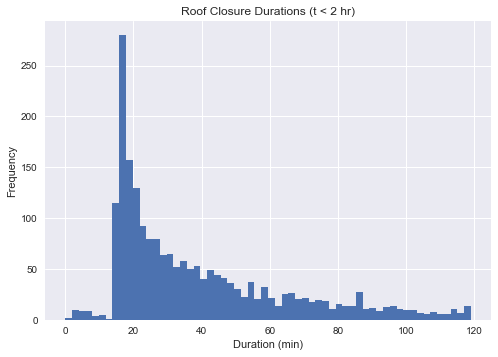

In [52]:
# plot a histogram showing frequencies of all status changes split by how long the previous state held
hist = roof_df[ roof_df.status.eq("Closed") & roof_df.delta.lt( timedelta(minutes = 120) ) ]['delta'].astype('timedelta64[m]').plot.hist(bins = 60)
hist.set_title("Roof Closure Durations (t < 2 hr)")
hist.set_xlabel("Duration (min)")
hist.plot()

[]

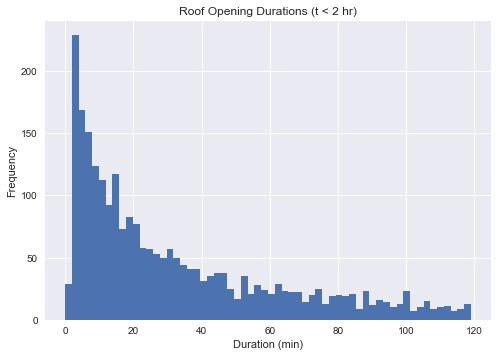

In [53]:
hist = roof_df[ roof_df.status.eq("Opened") & roof_df.delta.lt( timedelta(minutes = 120) ) ]['delta'].astype('timedelta64[m]').plot.hist(bins = 60)
hist.set_title("Roof Opening Durations (t < 2 hr)")
hist.set_xlabel("Duration (min)")
hist.plot()

[]

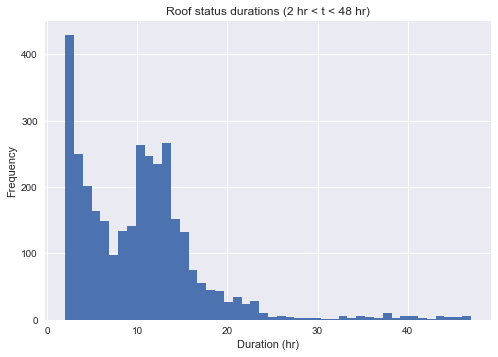

In [64]:
hist2 = roof_df[ roof_df.delta.gt( timedelta(minutes = 120) ) & roof_df.delta.lt( timedelta(hours = 48) ) ]['delta'].astype('timedelta64[h]').plot.hist(bins = 46)
hist2.set_title("Roof status durations (2 hr < t < 48 hr)")
hist2.set_xlabel("Duration (hr)")
hist2.plot()

<AxesSubplot:ylabel='Frequency'>

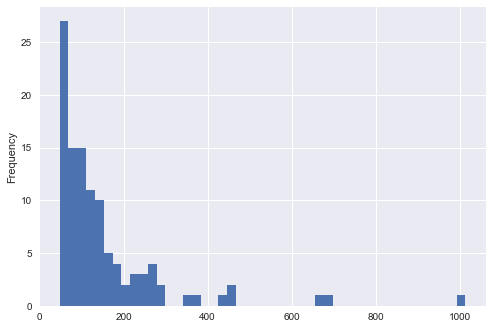

In [68]:
roof_df[ roof_df.status.eq("Closed") & roof_df.delta.gt( timedelta(hours = 48) ) & roof_df.delta.lt( timedelta(hours = 2000) ) ]['delta'].astype('timedelta64[h]').plot.hist(bins = 46)

In [511]:
# See overall time the system spent in each state
roof_df.groupby(by=['status']).sum() 

,delta
status,
Closed,1907 days 08:28:48.005000
Manual mode partly opened,32 days 20:01:55
Move_closing,96 days 08:14:29.037000
Move_openning,211 days 02:41:29.702000
Opened,481 days 05:12:18.454000
Stopped,0 days 00:01:03.314000


In [759]:
# there are some long closures... we need to filter these somehow, especially if some of these closures mix
# (closed due to rain) and (closed for other reason).
roof_df[ roof_df.delta > timedelta(days = 15) ]

,timestamp,status,delta
8600,2014-05-07 12:38:03.347,Move_openning,34 days 03:22:19.437000
8601,2014-06-18 18:26:56.255,Closed,42 days 05:48:52.908000
8774,2014-09-03 10:04:39.658,Move_openning,41 days 15:38:55.753000
9756,2015-03-31 19:12:13.909,Closed,18 days 06:29:20.500000
39097,2015-07-22 10:32:27.141,Move_closing,91 days 23:29:43.623000
39101,2015-08-26 18:22:21.086,Closed,28 days 07:29:29.235000
39108,2015-09-23 18:38:16.827,Closed,19 days 06:02:51.450000
41913,2016-12-07 16:37:55.068,Move_openning,16 days 12:07:47.201000
41948,2017-01-12 21:09:29.488,Closed,27 days 16:33:36.014000
41960,2017-01-31 23:47:27.174,Closed,18 days 19:02:14.045000


# Now compare with pluie data

In [9]:
s = "C:\\Users\\Matvey Solovyov\\OneDrive\\Documents\\UWA\\2021_S1\\GinginWx\\gingin-weather\\modelData.csv"

# will only need pluie values
wx_df = pd.read_csv(s, usecols=["date","pluie"], parse_dates=['date'])

# only for when rain sensor was working (see Precip RF Models for why these days)

wx_df = wx_df[ wx_df.date.gt( datetime( year = 2015, month = 1, day = 1 ) ) &
         wx_df.date.lt( datetime( year = 2019, month = 2, day = 1)) ]

wx_df = wx_df.sort_values(by=['date']).reset_index(drop=True)

# define a timedelta column for weather observations
wx_df.loc[:,'delta'] = wx_df.date - wx_df.date.shift(1)
wx_df.loc[0,'delta'] = timedelta( minutes = 5 )
wx_df

,date,pluie,delta
0,2015-01-01 00:00:59,0,0 days 00:05:00
1,2015-01-01 00:05:59,0,0 days 00:05:00
2,2015-01-01 00:11:00,0,0 days 00:05:01
3,2015-01-01 00:16:01,0,0 days 00:05:01
4,2015-01-01 00:21:01,0,0 days 00:05:00
...,...,...,...
359155,2019-01-31 23:35:11,0,0 days 00:05:01
359156,2019-01-31 23:40:11,0,0 days 00:05:00
359157,2019-01-31 23:45:13,0,0 days 00:05:02
359158,2019-01-31 23:50:14,0,0 days 00:05:01


### first check impact on roof_df

In [10]:
def find_pluie_indelta(row, weather_df):
    weather_chunk = weather_df[ (weather_df.date.le( row.timestamp )) & (weather_df.date.ge( row.timestamp - row.delta ))]
    if len( weather_chunk ) > 0:
        pluie = max( weather_chunk.pluie )
    else:
        pluie = 0
    return pluie

In [11]:
# # take section of roof data that we have weather data for:
# roof_df = roof_df[ roof_df.timestamp.le( wx_df.iloc[-1].date ) & roof_df.timestamp.ge( wx_df.iloc[0].date ) ]

roof_df.loc[:,'pluie'] = roof_df.apply( find_pluie_indelta, args=(wx_df,), axis = 1 )
roof_df.head()

,timestamp,status,delta,pluie
0,2013-11-27 21:43:19.488,Closed,0 days 01:00:00,0
1,2013-11-27 23:04:24.115,Opened,0 days 01:21:04.627000,0
2,2013-11-27 23:20:04.121,Closed,0 days 00:15:40.006000,0
3,2013-11-27 23:31:23.171,Opened,0 days 00:11:19.050000,0
4,2013-11-27 23:49:11.177,Closed,0 days 00:17:48.006000,0


#### File stuff

In [12]:
roof_df.to_csv( os.path.join( os.getcwd(), 'log_summaries\\roof_pluie.csv') , index=False)

In [4]:
roof_df = pd.read_csv( os.path.join( os.getcwd(), 'log_summaries\\roof_pluie.csv') , parse_dates=['timestamp'])
roof_df.delta = pd.to_timedelta( roof_df.delta )

## Now merge with majordome data for SKYLIGHT (maybe reason later)

In [13]:
mdome_df = pd.read_csv(  os.path.join( os.getcwd(), 'log_summaries\\majordome.csv'), parse_dates=['timestamp'] )
mdome_df.sort_values( by=['timestamp'], inplace=True )

In [14]:
skylights = ['SUNSET','SUNRISE','DAY','NIGHT','DAWN','DUSK']

sky_df = mdome_df[ mdome_df.desc.isin(skylights)].copy()
sky_df = sky_df.sort_values( by=['timestamp'] )

In [15]:
# for purposes of splitting weather/roof data, convenient to make skylight binary. 
sky_df.loc[ ~sky_df.desc.eq("NIGHT") , 'desc' ] = "DAY"

# where skylight is repeated, take only the first record
sky_df = sky_df[ ~sky_df.desc.eq( sky_df.shift(1).desc )  ].copy()

sky_df.reset_index(drop=True, inplace=True)

sky_df['delta'] = sky_df.shift(-1).timestamp - sky_df.timestamp
sky_df.loc[len(sky_df) - 1, 'delta'] = timedelta( hours = 1 )

sky_df

,timestamp,desc,delta
0,2013-11-24 18:52:27.520,DAY,0 days 00:02:32.859000
1,2013-11-24 18:55:00.379,NIGHT,0 days 20:26:53.980000
2,2013-11-25 15:21:54.359,DAY,0 days 03:33:57.221000
3,2013-11-25 18:55:51.580,NIGHT,0 days 10:14:05.043000
4,2013-11-26 05:09:56.623,DAY,0 days 13:46:48.933000
...,...,...,...
4625,2021-05-13 18:45:09.000,NIGHT,0 days 10:55:34
4626,2021-05-14 05:40:43.000,DAY,1 days 13:02:43
4627,2021-05-15 18:43:26.000,NIGHT,0 days 10:59:23
4628,2021-05-16 05:42:49.000,DAY,2 days 13:01:02


In [83]:
sky_df[ sky_df.desc.eq("NIGHT") & sky_df.delta.ge(timedelta(hours = 17)) ]

,timestamp,desc,delta
1,2013-11-24 18:55:00.379,NIGHT,0 days 20:26:53.980000
1563,2016-04-07 19:17:47.943,NIGHT,0 days 19:30:50.226000
1583,2016-04-17 19:06:30.320,NIGHT,1 days 11:42:11.091000
2169,2017-02-15 20:23:18.028,NIGHT,3 days 08:18:40.254000
2547,2017-09-06 19:13:20.949,NIGHT,0 days 19:27:07.223000
2549,2017-09-07 19:13:54.545,NIGHT,3 days 19:11:32.543000
2573,2017-10-06 21:04:10.911,NIGHT,2 days 10:41:21.104000
2617,2017-11-10 20:05:48.903,NIGHT,2 days 18:38:41.334000
3045,2018-06-16 18:37:41.012,NIGHT,127 days 10:37:20.988000
3091,2018-11-13 20:08:49.000,NIGHT,0 days 17:26:13


In [16]:
def find_skylights_andsplits(row, sky_df, ts, delta):
    sky_end = sky_df[ sky_df.timestamp.le( row[ ts ] ) ].iloc[-1]
    sky_start = sky_df[ sky_df.timestamp.le( row[ ts ] - row[ delta ] ) ].iloc[-1]
    
    # Look for skylights that were active while this roof_df row was as well
    sky = sky_df[ sky_df.timestamp.le(sky_end.timestamp) &
                  sky_df.timestamp.ge( sky_start.timestamp ) 
                ]
    
    new_row = row.copy()
    
    if len( sky ) > 1:
        # reset the index since will be working with .loc
        new_sky = sky.reset_index( drop = True )
        
        # change deltas to reflect the time applying to this row
        new_sky.loc[0, 'delta'] = (new_sky.iloc[0].timestamp + new_sky.iloc[0].delta) - (row[ts] - row[delta])
        new_sky.loc[ len(sky) - 1, 'delta' ] = row[ts] - new_sky.iloc[-1].timestamp
        
        # try filtering small skylights out to hopefully be left with a big one
        filtered_sky = new_sky[ new_sky.delta.gt( timedelta( minutes = 5 ) ) ]
        
        # if after extra filtering there are multiple contributing skylights, need to split
        if len( filtered_sky ) > 1:
            # Have more than one skylight, will need to split into multiple rows using explode
            # Set the timestamp to a list of timestamps into which we will then explode
            splits = list( filtered_sky.iloc[1:].timestamp )
            splits.append( new_row[ ts ] )

            new_row[ ts ] = splits
            new_row['skylight'] = row.name
        elif len( filtered_sky == 1 ):
            new_row['skylight'] = filtered_sky.iloc[0].desc
        else:
            # Must have multiple small skylight rows applicable. Here we will just take the maximum           
            new_row['skylight'] = new_sky.iloc[ new_sky.delta.idxmax() ].desc
            
    else:
        new_row['skylight'] = sky.iloc[-1].desc
        
    # add a column to keep track of long deltas that may be split by skylights:
    new_row['gt_48hr'] = (True if row[ delta ] > timedelta(hours = 48) else False)
    
    return new_row

In [17]:
def find_skylight_forsplits(row, sky_df, row_df, ts, delta):
    if row.skylight not in ["DAY", "NIGHT"]:
        new_row = row.copy()

        # now we can be sure actual skylight for this section is that which was active within 1 minute prior.
        new_row.skylight = sky_df[ sky_df.timestamp.le( row[ ts ] - timedelta( minutes = 1 ) ) ].iloc[-1].desc
        
        return new_row

In [18]:
def find_skylight( base_df, sky_df, ts, delta ):
    # base_df is the df for which we're finding corresponding skylight
    # ts and delta are the field names for the timestamp and delta fields in the base_df
    # sky_df is the df containing skylight data
    
    new_base_df = base_df.copy()
    new_base_df = new_base_df.apply( find_skylights_andsplits, args=(sky_df, ts, delta), axis = 1 ).explode(ts)
    
    # find splits only for the split df
    new_base_df[ ~new_base_df.skylight.isin( ['DAY','NIGHT'] ) ] = new_base_df[ 
        ~new_base_df.skylight.isin( ['DAY','NIGHT'] ) 
    ].apply( find_skylight_forsplits, args=(sky_df, base_df, ts, delta), axis = 1 )
    
    new_base_df[ delta ] = new_base_df[ ts ] - new_base_df[ ts ].shift(1)
    new_base_df.reset_index( drop=True, inplace=True )
    
    # if ts is date, its the wx_df and default timedelta is 5 min. Otherwise it's a roof one and default is 60min.
    default_td = (5 if ts=="date" else 60)
    new_base_df.loc[0, delta] = timedelta( minutes = default_td )
    
    return new_base_df

## Analyse roof based set using Skylight info

In [19]:
roof_df_sky = find_skylight( roof_df, sky_df, "timestamp", "delta" )
roof_df_sky.head()

,timestamp,status,delta,pluie,skylight,gt_48hr
0,2013-11-27 21:43:19.488,Closed,0 days 01:00:00,0,NIGHT,False
1,2013-11-27 23:04:24.115,Opened,0 days 01:21:04.627000,0,NIGHT,False
2,2013-11-27 23:20:04.121,Closed,0 days 00:15:40.006000,0,NIGHT,False
3,2013-11-27 23:31:23.171,Opened,0 days 00:11:19.050000,0,NIGHT,False
4,2013-11-27 23:49:11.177,Closed,0 days 00:17:48.006000,0,NIGHT,False


In [20]:
# re-do pluie
roof_df_sky.loc[:,'pluie'] = roof_df_sky.apply( find_pluie_indelta, args=(wx_df,), axis = 1 )
roof_df_sky.head()

,timestamp,status,delta,pluie,skylight,gt_48hr
0,2013-11-27 21:43:19.488,Closed,0 days 01:00:00,0,NIGHT,False
1,2013-11-27 23:04:24.115,Opened,0 days 01:21:04.627000,0,NIGHT,False
2,2013-11-27 23:20:04.121,Closed,0 days 00:15:40.006000,0,NIGHT,False
3,2013-11-27 23:31:23.171,Opened,0 days 00:11:19.050000,0,NIGHT,False
4,2013-11-27 23:49:11.177,Closed,0 days 00:17:48.006000,0,NIGHT,False


In [773]:
roof_df_sky[ roof_df_sky.delta.le(timedelta(minutes = 1)) ].groupby(['status']).delta.sum()

status
Closed                      0 days 00:00:56.304000
Manual mode partly opened          0 days 00:06:36
Move_closing                0 days 00:05:38.200000
Move_openning               0 days 00:34:54.686000
Opened                      0 days 00:04:28.948000
Name: delta, dtype: timedelta64[ns]

In [774]:
roof_df[ roof_df.delta.le(timedelta(minutes=1)) ].groupby(['status']).delta.sum()

status
Closed                      0 days 00:00:56.304000
Manual mode partly opened          0 days 00:06:36
Move_closing                0 days 00:05:38.200000
Move_openning               0 days 00:34:54.686000
Opened                      0 days 00:04:28.948000
Name: delta, dtype: timedelta64[ns]

#### File Stuff

In [21]:
roof_df_sky.to_csv( os.path.join( os.getcwd(), 'log_summaries\\roofdf_skylight.csv'), index=False )

In [2]:
roof_df_sky = pd.read_csv( os.path.join( os.getcwd(), 'log_summaries\\roofdf_skylight.csv'), parse_dates=['timestamp'] )
roof_df_sky.loc[:,'delta'] = pd.to_timedelta(roof_df_sky.delta)

In [30]:
## NOTE - the skylight splits deltas on day / night change. This means deltas spanning over multiple days should be split
## unless there is a problem, where the skylight is not recorded.
## Therefore, any delta greater than say 15 hours (rather than 48) is likely erroneous.

## Analysis

## Analyse weather data using skylight info

In [22]:
wx_df_sky = find_skylight(wx_df, sky_df, "date", "delta" ) 
wx_df_sky.head()

,date,pluie,delta,skylight,gt_48hr
0,2015-01-01 00:00:59,0,0 days 00:05:00,NIGHT,False
1,2015-01-01 00:05:59,0,0 days 00:05:00,NIGHT,False
2,2015-01-01 00:11:00,0,0 days 00:05:01,NIGHT,False
3,2015-01-01 00:16:01,0,0 days 00:05:01,NIGHT,False
4,2015-01-01 00:21:01,0,0 days 00:05:00,NIGHT,False


In [23]:
wx_df_sky.to_csv( os.path.join( os.getcwd(), 'log_summaries\\wx_df_skylight.csv'), index=False )

In [15]:
wx_df_sky = pd.read_csv( os.path.join( os.getcwd(), 'log_summaries\\wx_df_skylight.csv'), parse_dates = ['date'] )
wx_df_sky.loc[:,'delta'] = pd.to_timedelta(wx_df_sky.delta)
wx_df_sky.head()

,date,pluie,delta,skylight
0,2015-02-19 21:18:32,0,0 days 00:05:00,NIGHT
1,2015-02-19 21:23:33,1,0 days 00:05:01,NIGHT
2,2015-02-19 21:28:35,0,0 days 00:05:02,NIGHT
3,2015-02-19 21:33:36,0,0 days 00:05:01,NIGHT
4,2015-02-19 21:38:37,0,0 days 00:05:01,NIGHT


## Now combine weather data with roof data

In [24]:
def find_roof_status(row, roof_df):
    next_statuses = roof_df[ roof_df.timestamp.ge( row.date ) ]
    if len(next_statuses) > 0:
        current_state = next_statuses.iloc[0]
        change_delta = current_state.delta
        current_status = current_state.status
        change_id = current_state.name
    else:
        print("Didn't find status for row ", row.name)
        current_status, change_delta, change_id = np.nan, np.nan, np.nan
    
    row = row.copy()
    row['current_status'] = current_status
    row['change_delta'] = change_delta
    row['change_id'] = change_id
    return row

In [25]:
# find the corresponding status, time until the next change, and the time delta for that particular status
wx_df_sky_roof = wx_df_sky.apply( find_roof_status, args=(roof_df_sky,), axis=1 )

# and define a column for the time delta between weather rows
wx_df_sky_roof.delta = wx_df_sky_roof.date - wx_df_sky_roof.date.shift(1)
wx_df_sky_roof.loc[0, 'delta'] = timedelta(minutes = 5)
wx_df_sky_roof.head()

,date,pluie,delta,skylight,gt_48hr,current_status,change_delta,change_id
0,2015-01-01 00:00:59,0,0 days 00:05:00,NIGHT,False,Closed,0 days 04:45:15.732000,1550
1,2015-01-01 00:05:59,0,0 days 00:05:00,NIGHT,False,Closed,0 days 04:45:15.732000,1550
2,2015-01-01 00:11:00,0,0 days 00:05:01,NIGHT,False,Closed,0 days 04:45:15.732000,1550
3,2015-01-01 00:16:01,0,0 days 00:05:01,NIGHT,False,Closed,0 days 04:45:15.732000,1550
4,2015-01-01 00:21:01,0,0 days 00:05:00,NIGHT,False,Closed,0 days 04:45:15.732000,1550


In [26]:
wx_df_sky_roof.to_csv( os.path.join( os.getcwd(), 'log_summaries\\final_df.csv'), index=False )

In [27]:
wx_df_sky_roof.head()

,date,pluie,delta,skylight,gt_48hr,current_status,change_delta,change_id
0,2015-01-01 00:00:59,0,0 days 00:05:00,NIGHT,False,Closed,0 days 04:45:15.732000,1550
1,2015-01-01 00:05:59,0,0 days 00:05:00,NIGHT,False,Closed,0 days 04:45:15.732000,1550
2,2015-01-01 00:11:00,0,0 days 00:05:01,NIGHT,False,Closed,0 days 04:45:15.732000,1550
3,2015-01-01 00:16:01,0,0 days 00:05:01,NIGHT,False,Closed,0 days 04:45:15.732000,1550
4,2015-01-01 00:21:01,0,0 days 00:05:00,NIGHT,False,Closed,0 days 04:45:15.732000,1550


In [3]:
final_df = pd.read_csv( os.path.join( os.getcwd(), 'log_summaries\\final_df.csv'), parse_dates = ['date'] )
final_df.loc[:,'delta'] = pd.to_timedelta( final_df.delta )
final_df.loc[:,'change_delta'] = pd.to_timedelta( final_df.change_delta )

In [5]:
final_df.tail()

,date,pluie,delta,skylight,gt_48hr,current_status,change_delta,change_id
359288,2019-01-31 23:35:11,0,0 days 00:05:01,NIGHT,False,Opened,0 days 07:42:45,7268
359289,2019-01-31 23:40:11,0,0 days 00:05:00,NIGHT,False,Opened,0 days 07:42:45,7268
359290,2019-01-31 23:45:13,0,0 days 00:05:02,NIGHT,False,Opened,0 days 07:42:45,7268
359291,2019-01-31 23:50:14,0,0 days 00:05:01,NIGHT,False,Opened,0 days 07:42:45,7268
359292,2019-01-31 23:55:15,0,0 days 00:05:01,NIGHT,False,Opened,0 days 07:42:45,7268


In [97]:
final_df = wx_df_sky_roof.copy()

# Analysis of Final DF (and maybe roof df)

In [30]:
# first trim roof_df_sky to cover the same time that wx_df does
roof_df_trim = roof_df_sky[ roof_df_sky.timestamp.ge( final_df.date.iloc[0] ) & 
                            roof_df_sky.timestamp.le( final_df.date.iloc[-1] + timedelta( hours = 12 )) ]

In [31]:
# now get a set thats only NIGHT and have deltas of less than 48 hrs
# (48 hour deltas are generally caused by closures other than the weather - this is a crude assumption)

roof_df48N = roof_df_trim[ roof_df_trim.skylight.eq("NIGHT") & roof_df_trim.delta.le(timedelta(hours = 48)) ]
roof_df48N

,timestamp,status,delta,pluie,skylight,gt_48hr
1550,2015-01-01 01:23:13.264,Closed,0 days 04:45:15.732000,0,NIGHT,False
1551,2015-01-01 04:07:16.173,Opened,0 days 02:44:02.909000,0,NIGHT,False
1554,2015-01-01 22:16:03.617,Closed,0 days 01:40:21.358000,0,NIGHT,False
1555,2015-01-02 00:42:50.783,Opened,0 days 02:26:47.166000,0,NIGHT,False
1556,2015-01-02 04:07:37.889,Closed,0 days 03:24:47.106000,0,NIGHT,False
...,...,...,...,...,...,...
7248,2019-01-28 04:26:46.000,Opened,0 days 07:45:06,0,NIGHT,False
7252,2019-01-29 04:17:46.000,Opened,0 days 07:36:51,0,NIGHT,False
7260,2019-01-30 04:18:56.000,Opened,0 days 07:38:47,0,NIGHT,False
7264,2019-01-31 04:20:07.000,Opened,0 days 07:40:46,0,NIGHT,False


In [32]:
# [roof_df48N.status.eq('Stopped')]
100*(roof_df48N.groupby(['pluie','status']).delta.sum() / roof_df48N.delta.sum())

pluie  status       
0      Closed           35.614337
       Move_closing      4.086737
       Move_openning     1.938109
       Opened           28.574347
       Stopped           0.000153
1      Closed           21.702583
       Move_closing      1.275564
       Move_openning     3.118407
       Opened            3.689763
Name: delta, dtype: float64

<AxesSubplot:ylabel='Frequency'>

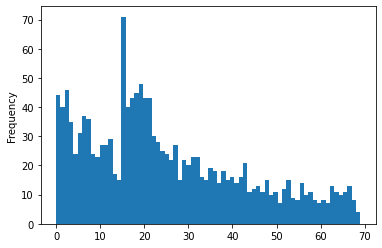

In [33]:
roof_df48N[roof_df48N.delta.le(timedelta(minutes = 70))].delta.astype('timedelta64[m]').plot.hist(bins=70)

In [4]:
# Now do the same for final_df (wx based)
final_df48N = final_df[ final_df.skylight.eq("NIGHT") & final_df.change_delta.le(timedelta(hours = 48)) &
                        final_df.delta.le( timedelta( hours = 2 ) )]
# but also when theres a big gap in weather data, likely something went wrong outside of weather,
# so filter those out as well

In [35]:
100*(final_df48N.groupby(['pluie','current_status']).delta.sum() / final_df48N.delta.sum())

pluie  current_status
0      Closed            51.475223
       Move_closing       5.441399
       Move_openning      4.129348
       Opened            31.541705
1      Closed             5.128250
       Move_closing       0.186582
       Move_openning      1.145100
       Opened             0.952395
Name: delta, dtype: float64

In [36]:
100*(final_df48N.groupby(['pluie','current_status']).size() / len(final_df48N))

pluie  current_status
0      Closed            51.532029
       Move_closing       5.273389
       Move_openning      4.117810
       Opened            31.669649
1      Closed             5.125278
       Move_closing       0.188225
       Move_openning      1.133208
       Opened             0.960411
dtype: float64

In [37]:
final_df20 = final_df48N.copy()
final_df20.loc[ final_df20.change_delta.le( timedelta(minutes = 20) ) & final_df20.current_status.eq("Closed") , 'current_status' ] = "Closed_lt20"

In [38]:
100*(final_df20.groupby(['pluie','current_status']).size() / len(final_df20))

pluie  current_status
0      Closed            51.069952
       Closed_lt20        0.462077
       Move_closing       5.273389
       Move_openning      4.117810
       Opened            31.669649
1      Closed             5.067422
       Closed_lt20        0.057856
       Move_closing       0.188225
       Move_openning      1.133208
       Opened             0.960411
dtype: float64

In [ ]:
# Difference in proportion for weather dataset vs roof dataset is because the roof_df takes an aggregate of pluie
# by taking max - time spent raining is much more than actual.

# ALSO when we do predictions -> prediction field - NEXT pluie, use current pluie as additional field.

# Choosing to consider DUSK/DAWN as NIGHT would also probably have significant effect on number of (NIGHT Closed No Rain)
# Perhaps can keep as DUSK/DAWN -> only consider NIGHT? would reduce the total data but shouldn't introduce bias

<AxesSubplot:ylabel='Frequency'>

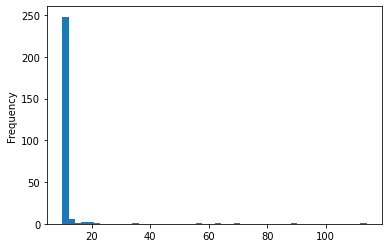

In [127]:
roof_df_sky[ roof_df_sky.skylight.eq("NIGHT") & roof_df_sky.status.eq('Closed') & roof_df_sky.delta.le(timedelta(days = 5)) & roof_df_sky.delta.gt(timedelta(hours  = 10)) ].delta.astype('timedelta64[h]').plot.hist(bins=48)

In [116]:
roof_df[ roof_df.delta.ge(timedelta(days = 10)) ]

,timestamp,status,delta,pluie
157,2014-01-13 21:37:46.227,Closed,10 days 17:06:40.512000,0
280,2014-02-22 20:00:04.068,Closed,10 days 16:22:28.398000,0
8600,2014-05-07 12:38:03.347,Move_openning,34 days 03:22:19.437000,0
8601,2014-06-18 18:26:56.255,Closed,42 days 05:48:52.908000,0
8774,2014-09-03 10:04:39.658,Move_openning,41 days 15:38:55.753000,0
8799,2014-09-18 18:14:47.386,Closed,11 days 13:00:33.018000,0
9756,2015-03-31 19:12:13.909,Closed,18 days 06:29:20.500000,1
39097,2015-07-22 10:32:27.141,Move_closing,91 days 23:29:43.623000,1
39101,2015-08-26 18:22:21.086,Closed,28 days 07:29:29.235000,1
39108,2015-09-23 18:38:16.827,Closed,19 days 06:02:51.450000,1


# Analysis using change_id to find gt48hr deltas

In [39]:
final_df[ final_df.change_delta.gt(timedelta(hours=48)) & ~final_df.change_id.isin( roof_df_sky[ roof_df_sky.gt_48hr ].index )]

,date,pluie,delta,skylight,gt_48hr,current_status,change_delta,change_id


In [6]:
# Now do the same for final_df (wx based)
final_df48N = final_df[ final_df.skylight.eq("NIGHT") & final_df.delta.le( timedelta( hours = 2 ) ) & 
                        ~final_df.change_id.isin( roof_df_sky[ roof_df_sky.gt_48hr ].index )]
# but also when theres a big gap in weather data, likely something went wrong outside of weather,
# so filter those out as well

In [8]:
final_df48N.delta.sum()

Timedelta('258 days 06:28:16.015000')

In [7]:
100*(final_df48N.groupby(['pluie','current_status']).delta.sum() / final_df48N.delta.sum())

pluie  current_status
0      Closed            37.205383
       Move_closing       0.102525
       Move_openning      1.316259
       Opened            55.590450
1      Closed             4.027297
       Move_openning      0.079545
       Opened             1.678541
Name: delta, dtype: float64

In [46]:
len(final_df48N[ final_df48N.current_status.eq('Closed') & final_df48N.pluie.eq(0) ]) / len(final_df48N[ final_df48N.pluie.eq(0) ])

0.3946656692369663

In [42]:
final_df48N.groupby(['pluie','current_status']).delta.sum()

pluie  current_status
0      Closed            96 days 02:09:53.760000
       Move_closing              0 days 06:21:18
       Move_openning      3 days 09:35:16.531000
       Opened           143 days 13:45:28.736000
1      Closed            10 days 09:37:50.988000
       Move_openning             0 days 04:55:50
       Opened                    4 days 08:02:38
Name: delta, dtype: timedelta64[ns]

In [76]:
final_df20 = final_df48N.copy()
final_df20.loc[ final_df20.change_delta.le( timedelta(minutes = 20) ) & final_df20.current_status.eq("Closed") , 'current_status' ] = "Closed_lt20"

100*(
final_df20.groupby(['pluie','current_status']).delta.sum() / final_df20.delta.sum())

pluie  current_status
0      Closed            36.411290
       Closed_lt20        0.794094
       Move_closing       0.102525
       Move_openning      1.316259
       Opened            55.590450
1      Closed             3.926071
       Closed_lt20        0.101226
       Move_openning      0.079545
       Opened             1.678541
Name: delta, dtype: float64

In [8]:
tp = len( final_df48N[ final_df48N.pluie.eq(1) & final_df48N.current_status.eq("Closed") ] )
tn = len( final_df48N[ final_df48N.pluie.eq(0) & final_df48N.current_status.eq("Opened") ] )
fp = len( final_df48N[ final_df48N.pluie.eq(0) & final_df48N.current_status.eq("Closed") ] )
fn = len( final_df48N[ final_df48N.pluie.eq(1) & final_df48N.current_status.eq("Opened") ] )

In [9]:
total = (fp + fn + tp + tn)
acc = (tp + tn) / total
acc

0.605526670518005

In [11]:
b_acc = 0.5*((tp / (tp + fn))+(tn / (tn + fp)))
b_acc

0.6519948592492959

In [83]:
veri_scores = pd.Series([0.1]*7, index = ['acc','bias', 'pod', 'far', 'ts', 'ets', 'or'])
    
# Accuracy Score
# veri_scores['acc']  = accuracy_score(y_test,y_pred)

# # Balanced Accuracy Score
# veri_scores['b_acc'] = balanced_accuracy_score(y_test,y_pred)

# Bias Score
veri_scores['bias'] = (tp + fp)/(tp + fn)

# Probability of Detection
veri_scores['pod']  = (tp)/(tp + fn)

# False Alarm Ratio
veri_scores['far']  = (fp)/(tp + fp)

# Threat Score
veri_scores['ts']   = (tp)/(tp + fp + fn)

# Equitable Threat Score ( accounting for random tp's )
r_tp = ((tp + fn)*(tp + fp)) / total
veri_scores['ets'] = (tp - r_tp)/(tp + fp + fn - r_tp)

# Odds Ratio
veri_scores['or']   = (tp * tn) / (fn * fp) 

In [84]:
veri_scores

acc     0.100000
bias    7.214760
pod     0.704556
far     0.902345
ts      0.093813
ets     0.040379
or      3.568677
dtype: float64